# Optimization of Maximum Independent Set on unit disk graphs 


This example will show optimization of MIS using neutral atoms, and follow example 5. Let us begin by importing the requisite packages. You can run these locally by running ```pip install amazon-braket-sdk``` and ``` pip install quera-ahs-utils```. For more details, see https://github.com/aws/amazon-braket-sdk-python and https://github.com/QuEraComputing/quera-ahs-utils.

In [1]:
from braket.ahs.driving_field import DrivingField
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.aws import AwsDevice
from quera_ahs_utils.plotting import plot_task

import quera_ahs_utils.drive as drive
import quera_ahs_utils.ir as ir

import networkx as nx
import numpy as np
import json, os



RAMP_TIME = 0.06e-6
MIN_TIME_STEP = 0.05e-6

def batch_submit(qpu: AwsDevice, ahs_programs: list, json_output_filename: str, shots: int=100):
    
    def submit_and_report(qpu: AwsDevice, ahs_program: AnalogHamiltonianSimulation, metadata):
        discretize_ahs_program = ahs_program.discretize(qpu)
        task = qpu.run(discretize_ahs_program, shots=shots)
        ahs_ir = discretize_ahs_program.to_ir()
        arn = task._arn
        task_bundle = {
            "task":eval(ahs_ir.json()),
            "metadata":str(metadata) # use eval to free data. 
        }
    
        return arn,task_bundle
    
    if not os.path.isfile(json_output_filename): # prevent accidental resubmission. 
        tasks = {}
        for ahs_program,*metadata in ahs_programs:
            arn, task_bundle = submit_and_report(qpu, ahs_program, metadata)
            tasks[arn] = task_bundle
            
        with open(json_output_filename,"w") as IO:
            json.dump(tasks,IO,indent=2)
    else:
        raise RuntimeError("resubmitting jobs not allowed, please use different filename.")

# Defective King's graph and quantum annealing

First, we define the problem instances and how to prepare the state. Following https://arxiv.org/abs/2202.09372 , we choose defective kings graphs, which are next-nearest-neighbor grid graphs, where we drop out a random subset of 30% of vertices. The protocol we choose is a simple adiabatic sweep, where we scan different final detunings as a simple grid search variational optimization.

In [2]:

def generate_random_graph(Lx: int, Ly: int, p_filled: float = 0.7, lattice_spacing: float = 5.0e-6, SEED: int = 0):
    randgen = np.random.RandomState(SEED)
    register = AtomArrangement()

    for ix in range(Lx):
        for iy in range(Ly):
            site_type = (SiteType.FILLED if randgen.uniform()<p_filled else SiteType.VACANT)
            
            x = np.around(ix*lattice_spacing, 13)
            y = np.around(iy*lattice_spacing, 13)            
            
            register.add((x, y),site_type)
    
    return register

def graph_optimization_ahs_program(final_detuning: float, **kwargs):
    register = generate_random_graph(15, 15, **kwargs)
        
    ahs_program = AnalogHamiltonianSimulation(
            register=register,
            hamiltonian=drive.adiabatic_drive(
                t_ramp_up = 0.3e-6, 
                t_ramp_down = 0.3e-6, 
                t_sweep = 1.6e-6, 
                Omega_max = 15e6, 
                Delta_start = -30, 
                Delta_end = final_detuning
            )
        )
    return ahs_program
    
    
final_detunings = np.linspace(0,80,81)

optimization_ahs_programs = [(graph_optimization_ahs_program(final_detuning), final_detuning, ) for final_detuning in final_detunings]

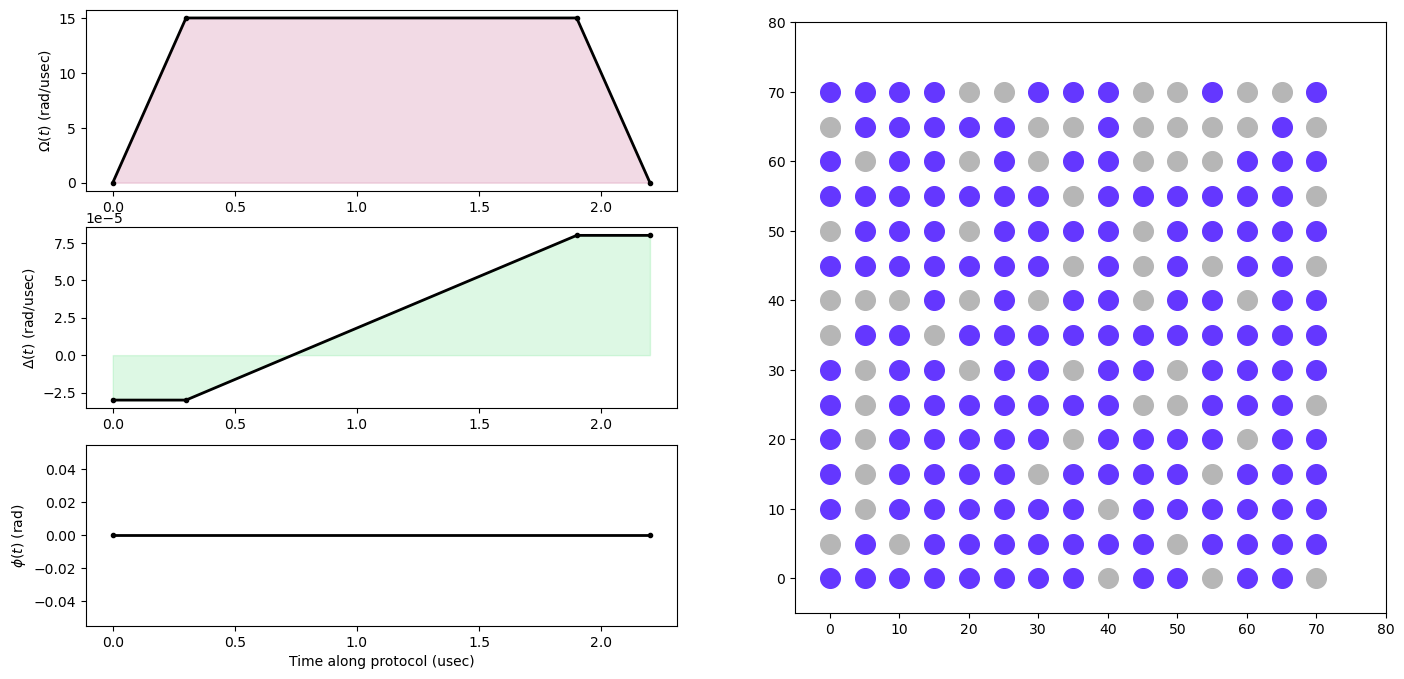

In [3]:
plot_task(optimization_ahs_programs[-1][0],show_register=True)

The tasks can be submitted in the usual way by using ```batch_submit``` or iterate through each task individually.

In [ ]:
raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila"
)

batch_submit(qpu, optimization_ahs_programs, "optimization_tasks.json", shots=1000)

In [ ]:
from braket.aws import AwsQuantumTask
import json

optimization_tasks = []
with open("optimization_tasks.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        edges, final_detuning = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        optimization_tasks.append((task, final_detuning))

### Graph analysis code

Here we define a few helper functions that will assist in optimization. As discussed in the whitepaper, results directly from Aquila are rarely optimal: some times there are Rydberg excitations which violate the independent set constraint, and other times the solution is not maximal, which means it is possible to add extra vertices to the solution without violating the independent set constraint.

Here, solutions are minimally post-processed using a simple "greedy add" and "Greedy remove" procedure. The "greedy add" works as follows. First, a graph and initial solution is provided. Then, a "cost" is assigned to each vertex. For a weighted graph, this cost is a linear function of the sum of the weights of all of the neighbors that are not yet blocked by the independent set, minus the weight of that vertex. For an unweighted graph, this cost is simply the number of neighbors that are not yet blocked by the independent set.

The greedy algorithm then greedily adds the vertex with the smallest cost; for an unweighted graph this is simply the vertex that blocks the fewest additional vertices from potentially being added to the independent set. Then, the algorithm iterates until no more vertices can be added to the set and the solution is maximal. The time to solution scales quadratically with the number of vertices, as at each of the order N steps the algorithm needs to compute the cost of each node.

A similar algorithm can be employed to remove independent set violations. This is done by computing the greedy mIS on the subgraph of the full graph generated by the vertices in the initial solution. If the initial solution is the empty set, the subgraph is empty and thus also returns the empty set. If the initial solution is an independent set, there are no edges and the independent set is the entire subgraph. If the initial solution is all vertices in the graph, then the subgraph is the whole graph and thus the algorithm simply finds a greedy mIS.



In [4]:
def get_UDG(positions,radii) ->nx.Graph:
    """
    Compute a unit disk graph based on some list of positions in 2d
    positions - position of each vertx
    radii     - Radius of the unit disk graph. If two disks overlap, there is an edge.
    """
    
    positions = np.array(positions)
    N = len(positions)

    # Construct the unit disk graph
    G = nx.Graph((np.sqrt((positions[:,0:1] - positions[:,0:1].T)**2 + (positions[:,1::] - positions[:,1::].T)**2) + np.diag(np.ones(N))*1e99)<(2*radii))
    return G


def greedy_weighted_mIS(G,weights = None,soln = set([]),bias = 1000):
    
    soln = set(list(soln))
    
    if len(G.nodes)==0:
        return set([])
    
    if weights is None:
        weights = np.ones(max(list(G.nodes))+1)    
    
    reduce = lambda ind,graph: graph.subgraph(set(graph.nodes).difference(graph.neighbors(ind)).difference([ind]))
    degree = lambda graph: np.array([bias*sum(weights[list(graph.neighbors(ind))]) - weights[ind] for ind in graph.nodes])
    
    Gsub = nx.Graph(G)
    for ind in list(soln):
        if ind in Gsub:
            Gsub = reduce(ind,Gsub)

    while len(Gsub.nodes)>0:
        deg = degree(Gsub) + 1e-5*np.random.rand(len(Gsub.nodes))
        
        minind = list(Gsub.nodes)[np.argmin(deg)]
        Gsub = reduce(minind,Gsub)
        soln.add(minind)
        

    return set(list(soln))



def greedy_remove(G,soln,weights = None):
    """
    Greedily removes vertices that violate independent set constraint
    G - graph
    soln - indices which are part of the independent set. May have violations.
    """
    soln = set(list(soln))
    Gsub = G.subgraph(soln)
    return( set(list(greedy_weighted_mIS(Gsub, weights=weights, soln=set([])))))


This post-processing is useful because it gives classical-only performance in a certain limit. In this case, if the solution is the all-zeros or all-ones bit string, then the post-processing returns the same as classical. In this way, we can direcly benchmark the performance against the classical only version as a characterization of quantum advantage.



In [6]:
pos_filled = np.array([atom.coordinate for atom in optimization_ahs_programs[0][0].register if atom.site_type == SiteType.FILLED])*1e6
graph = get_UDG(pos_filled,6)

classical_IS_sizes = np.asarray([len(greedy_weighted_mIS(graph)) for i in range(1000)])

Now, for each task, do the hybrid post-processing procedure. Note that here we have commented out ```optimization_tasks``` and replaced it with the input tasks; similarly the shot measurements have been replaced with fake data. If you run these tasks yourself you may switch these comments to execute the correct code.

In [7]:
#tasks_iter = optimization_tasks
tasks_iter = optimization_ahs_programs

results = []
for task,final_detuning in tasks_iter[0:10]:
    pos_filled = np.array([atom.coordinate for atom in task.register if atom.site_type == SiteType.FILLED])*1e6
    graph = get_UDG(pos_filled,6)

    #shots = pp.get_shots_braket_sdk_results(task.result())
    shots = [np.random.choice(2,size=len(graph.nodes),p=[0.22,0.78]) for ctr in range(100)]

    rydberg_counts = []
    quantum_IS_sizes = []
    hybrid_IS_sizes = []

    for shot in shots:
        rydberg_nodes = set(np.argwhere(shot==0).ravel())
        quantum_solution = greedy_remove(graph, soln=rydberg_nodes)
        hybrid_solution = greedy_weighted_mIS(graph, soln=set(list(quantum_solution)))

        rydberg_counts.append(len(rydberg_nodes))
        quantum_IS_sizes.append(len(quantum_solution))
        hybrid_IS_sizes.append(len(hybrid_solution))
        
    
    results.append(( final_detuning, rydberg_counts, quantum_IS_sizes, hybrid_IS_sizes ))

final_detunings = np.array([x[0] for x in results])
average_rydberg = np.array([np.average(x[1]) for x in results])
average_quantum = np.array([np.average(x[2]) for x in results])
average_hybrid = np.array([np.average(x[3]) for x in results])
average_classical = np.average(classical_IS_sizes)

Plot results! Observe that, as might be expected, choosing a random subset of vertices to initialize the greedy post-processing performs worse than simply choosing the all-zeros or all-ones bitstring. For real data please see the whitepaper example 5.

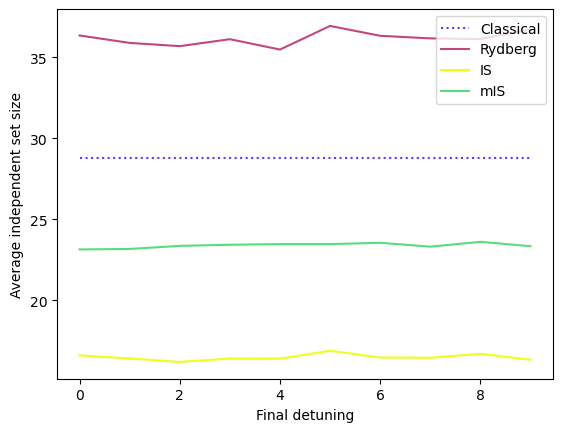

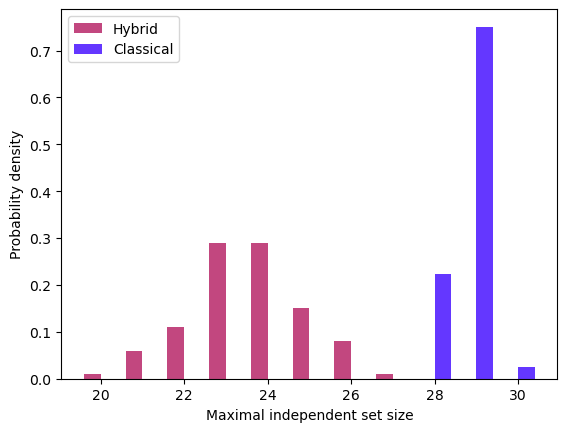

In [8]:
import matplotlib.pyplot as plt

RED = "#C2477F"
PURPLE = "#6437FF"
YELLOW = "#edff1a"
YELLOW2= "#a8b512"
GREEN  = "#55de79"
BLACK  = "#878787"

indsort = np.argsort(final_detunings)
plt.plot(final_detunings, average_classical*np.ones_like(final_detunings), 
         color=PURPLE, linestyle=":", label="Classical")
plt.plot(final_detunings[indsort], average_rydberg[indsort], color=RED, label="Rydberg")
plt.plot(final_detunings[indsort], average_quantum[indsort], color=YELLOW, label="IS")
plt.plot(final_detunings[indsort], average_hybrid[indsort], color=GREEN, label="mIS")
plt.xlabel("Final detuning")
plt.ylabel("Average independent set size")
plt.legend()

maxind = np.argmax(average_hybrid)

best_hybrid_data = results[maxind][3]
vals_hybrid,cts_hybrid = np.unique(best_hybrid_data,return_counts = True)
vals_classical,cts_classical = np.unique(classical_IS_sizes,return_counts = True)

plt.figure()
plt.bar(vals_hybrid-0.2,cts_hybrid/sum(cts_hybrid),width=0.4,color=RED,label="Hybrid")
plt.bar(vals_classical+0.2,cts_classical/sum(cts_classical),width=0.4,color=PURPLE,label="Classical");
plt.legend()
plt.xlabel("Maximal independent set size")
plt.ylabel("Probability density");
